# Modeling Photoreceptors with a relative capture noise level

In this tutorial, we will build a photoreceptor model with a relative capture noise level. The noise level will take the calculated relative photon capture and round each value to the given noise level. For a relative capture below the noise level (e.g. for a relative capture of 0), the capture will be set to the noise level. 

First, let's import dreye and create spectral sensitivities:

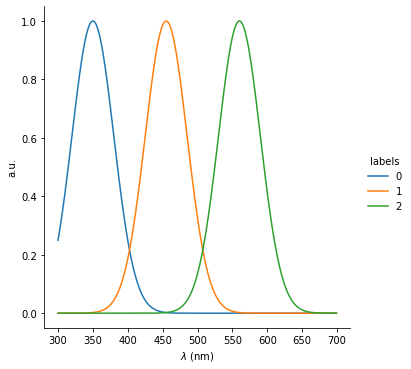

In [1]:
import numpy as np
from scipy.stats import norm
import dreye
from dreye import get_led_spectra_container
from dreye import IndependentExcitationFit

wls = np.arange(300, 700, 1.0)

sensitivity = dreye.Sensitivity(
    dreye.create_gaussian_spectrum(
    wls, 
    [350, 455, 560], 
    std=30, units=None, max_normalized=True
))

sensitivity.plot()

Next, let's build our photoreceptor model. We will build to model; one that includes capture noise and another that does not:

In [2]:
pr = dreye.LogPhotoreceptor(
    sensitivity, 
    capture_noise_level=1e-5
)
pr_ = dreye.LogPhotoreceptor(
    sensitivity, 
)

To start to understand the differences between these two models, let's create an illuminant and a background illuminant, and calculate the photoreceptor excitation for each model:

In [3]:
illuminant = dreye.create_gaussian_spectrum(
    wls, 
    np.arange(400, 600, 20), 
    std=10, units='uE'
)
background = dreye.Spectrum(
    np.ones(len(wls))/len(wls), 
    wls, units='uE'
)
illuminant_ = background + illuminant

excitation = pr.excitation(
    illuminant_[:, 0], 
    background=background, return_units=True
)
excitation_ = pr_.excitation(
    illuminant_[:, 0], 
    background=background, return_units=True
)

print("Excitation for model with noise:")
print(excitation)
print("Excitation for model without noise:")
print(excitation_)

Excitation for model with noise:
[[0.9236118668447089 0.7476306309843208 9.999950000398841e-06]] dimensionless
Excitation for model without noise:
[[0.9236101519575644 0.7476292046025864 1.3931518197385637e-05]] dimensionless


As you can see, the values for the excitations changes when the model includes a noise level. The difference is more obvious when we want to calculate the excitation at complete darkness. In the noiseless case, we will get a `RuntimeWarning` as a capture of 0 for the `LogPhotoreceptor` is undefined:

In [4]:
excitation = pr.excitation(
    np.zeros(len(wls)), 
    background=background, return_units=False
)
print(excitation)
# will throw a runtime warning
excitation_ = pr_.excitation(
    np.zeros(len(wls)),
    background=background, return_units=False
)
print(excitation_)

[[-11.51292546 -11.51292546 -11.51292546]]
[[-inf -inf -inf]]


/Users/matthias.christenson/Documents/dreye/dreye/core/photoreceptor.py:603: RuntimeWarning: divide by zero encountered in log
  return np.log(arr)


Next, let's create some dummy LED measurements and in order to see if there is any difference in the two models when we try to fit excitation values.

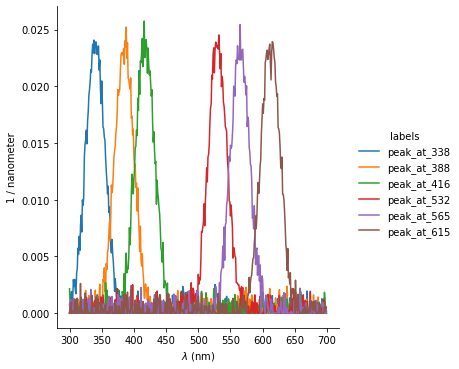

In [5]:
max_ints = np.array([100, 110, 90, 120, 130, 150])
measured_spectra = get_led_spectra_container(
    led_spectra=(
        norm.pdf(
            wls[:, None], 
            np.array([340, 385, 417, 530, 565, 612])[None], 
            15
        ) + np.random.normal(0, 0.001, (wls.size, 6))
    ), 
    intensity_bounds=(np.zeros(6), max_ints), 
    wavelengths=wls, 
    output_bounds=(0, 5), 
    intensity_units='microphotonflux', 
    output_units='volts', 
    steps=10
)

measured_spectra.normalized_spectra.plot()

Let's build our estimators in order to fit excitation values. We want to perform a silent substitution experiment for the first opsin, so we set it's `fit_weights` lower than that of others:

In [11]:
est = IndependentExcitationFit(
    photoreceptor_model=pr, 
    fit_weights=np.array([0.01, 1, 1]), 
    background=background, 
    bg_ints=np.ones(len(measured_spectra))*1,
    measured_spectra=measured_spectra, 
    background_only_external=True,
    smoothing_window=5, 
)
est_ = IndependentExcitationFit(
    photoreceptor_model=pr_, 
    fit_weights=np.array([0.01, 1, 1]), 
    background=background, 
    bg_ints=np.ones(len(measured_spectra))*1,
    measured_spectra=measured_spectra, 
    background_only_external=True,
    smoothing_window=5, 
)

Let's try to perform our silent substitution experiment by passing an `X` array to our model `fit` method that is zero except for the first opsin. We will try different excitations for our first opsin:

In [12]:
X = np.array([
    [1, 0, 0], 
    [10, 0, 0], 
    [100, 0, 0], 
])
est.fit(X)
est_.fit(X)

print(est.fitted_excite_X_)
print(est_.fitted_excite_X_)

/Users/matthias.christenson/Documents/dreye/dreye/estimators/excitation_models.py:225: UserWarning: `background` differs from `bg_ints`. Assuming background is the sum of an external source and `bg_ints`.
  warnings.warn(
/Users/matthias.christenson/Documents/dreye/dreye/estimators/excitation_models.py:225: UserWarning: `background` differs from `bg_ints`. Assuming background is the sum of an external source and `bg_ints`.
  warnings.warn(


[[ 9.99999327e-01  0.00000000e+00  0.00000000e+00]
 [ 2.74154494e+00  9.99500333e-04 -7.00024501e-05]
 [ 2.75823178e+00  1.34392869e-02 -8.80387427e-04]]
[[ 1.00000000e+00 -2.22044605e-16  2.22044605e-16]
 [ 2.74160171e+00  1.02223072e-03 -6.82617417e-05]
 [ 2.75823197e+00  1.34412691e-02 -8.84967582e-04]]


In [13]:
print(est.fitted_intensities_)
print(est_.fitted_intensities_)

[[3.80270110e+00 2.32607235e+00 6.02762732e-01 8.32566494e-01
  1.20236920e+00 4.15983207e-01]
 [3.16597390e+01 2.29881247e-04 1.82691630e-30 2.64713083e-06
  1.37035728e+00 5.84473431e-04]
 [3.21964763e+01 1.54325063e-03 6.67960992e-10 1.57429942e-06
  1.35466858e+00 6.26941635e-03]]
[[3.80270399e+00 2.32607391e+00 6.02762254e-01 8.32566353e-01
  1.20236919e+00 4.15983208e-01]
 [3.16616223e+01 1.16220498e-04 1.52833277e-06 1.75807442e-14
  1.37039388e+00 3.37299244e-04]
 [3.21964763e+01 1.54325063e-03 6.67960992e-10 1.57429942e-06
  1.35466858e+00 6.26941635e-03]]


As can be seen in the fitted excitations, the noise-limited photoreceptor model fits slightly different excitations values but overall the fits are fairly similar. Similarly for the chosen intensity values, there are slight differences.